In [48]:
import pandas as pd
# import pandas_profiling
import os

DATA_DIR = "."
DUMP_FILE_EN = os.path.join(DATA_DIR, "abstract_en.pkl")
DUMP_FILE_KO = os.path.join(DATA_DIR, "abstract_ko.pkl")

data_en = pd.read_pickle(DUMP_FILE_EN)
data_ko = pd.read_pickle(DUMP_FILE_KO)


In [9]:
# # 리포트 생성
# pr_en = data_en.profile_report()
# # pr_en = pandas_profiling.ProfileReport(data_en)
# pr_ko = data_ko.profile_report()
# # pr_ko = pandas_profiling.ProfileReport(data_ko)

# pr_en.to_file('./pr_en_report.html')
# pr_ko.to_file('./pr_ko_report.html')

AttributeError: 'DataFrame' object has no attribute 'profile_report'

In [ ]:
pr_en

In [8]:
pr_ko

In [49]:
### 데이터 전처리
### 1. label번호 바꾸기 (db랑 비교)
### 2. train_data / test_data 나누기

subjects = ["기타자연과학", "대기과학", "물리학", "생물학", "생활과학", "수학", "자연과학", "자연과학일반", "지구과학", "지질학", "천문학", "통계학", "해양학", "화학", "건축공학", "고분자공학", "공학", "공학일반", "교통공학", "금속공학", "기계공", 
"기타공학", "농공학", "산림공학", "산업공학", "생물공학", "섬유공학", "안전공학", "원자력공학", "의공학", "자동차공학", "자원공학", "재료공학", "전기공학", "전자/정보통신공학", "제어계측공학", "조선공학", "컴퓨터학", "토목공학", "항공우주공학", "해양공학", "화학공학", "환경공학"
]

results = []
for idx in range(0, len(data_en)):
    if data_en['subject'][idx] is None:
        results.append(0)
        continue
    
    i = 0
    flag = True
    for subject in subjects:
        i += 1
        if data_en['subject'][idx] == subject:
#             print(data_en['subject'][idx])
            flag = False
            results.append(i)
            break
    
    if flag is True:
        results.append(0)

data_en['label'] = results
print(data_en.head(20))


    id                                          title_kor title_eng  \
0    1  Characterization of Electrical Heating of Grap...             
1    2  The textile products labelling analysis and re...             
2    3  Consumer resistance to innovation: smart clothing             
3    4  Experimental design and evaluation of a moistu...             
4    5  Application of persimmon (Diospyros kaki L.) p...             
5    6  Constructing cultural identity through weaving...             
6    7  On the fashionalization of digital devices: a ...             
7    8  Top online luxury apparel and accessories reta...             
8    9  Changing structures of B2B networks in the Jap...             
9   10  Predicting clothing behaviors of Generation Y ...             
10  11  Product experiences of clothing attachment in ...             
11  12  Physiological and subjective burden when weari...             
12  13  ‘Neo-Crosssexual’ fashion in contemporary men’...             
13  14

In [50]:
df = data_en.loc[:, ["abstract", "label"]]

# 특수 문자, 길이 짧은 단어, 소문자 변환
df["abstract_clean"] = df["abstract"].str.replace("[^a-zA-Z]", " ")
df["abstract_clean"] = df["abstract_clean"].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df["abstract_clean"] = df["abstract_clean"].apply(lambda x: x.lower())

# Null 값 및 empty값 확인
df["abstract_clean"].isnull().values.any()
df.replace("", float("NaN"), inplace=True)
df["abstract_clean"].isnull().values.any()
# print(df.head(1))

True

In [51]:
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.text import Tokenizer

# Null 값 제거
print('총 샘플 수: ', len(df))
df.dropna(inplace=True)
df = df[df.label != 0]
print('총 샘플 수: ', len(df))

# 불용어 제거
stop_words = stopwords.words('english')
tokenized_doc = df['abstract_clean'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))


총 샘플 수:  49191
총 샘플 수:  42925
총 샘플 수 : 42925


C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


32863    [study, annual, power, production, wind, farm,...
42508    [loxp, integration, system, developed, allow, ...
5821     [hydrologic, models, useful, tool, understandi...
23245    [presence, narrow, stripe, coating, appears, l...
35499    [purpose, study, evaluate, reliability, effect...
                               ...                        
37163    [aspergillosis, life, threatening, disease, in...
19690    [ionic, conductivities, yttria, doped, ceria, ...
27550    [great, progress, display, performances, achie...
39102    [objectives, study, aims, classify, groups, ac...
31598    [study, aimed, develop, validate, highly, sens...
Name: tokenized_doc, Length: 34340, dtype: object
2463     [background, anti, llerian, hormone, plays, cr...
1334     [accidents, construction, sites, involving, fi...
7154     [paper, proposes, transistor, dynamic, random,...
14894    [spin, valves, nanostructure, cofe, cofe, thre...
31250    [demagnetization, crucial, national, defense, ...
      

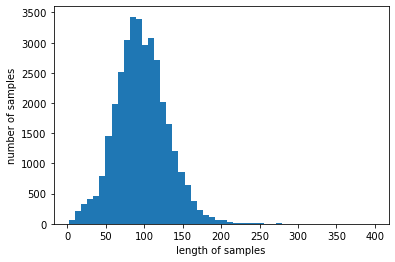

In [52]:
### Splitting Data
### https://wikidocs.net/33274
import numpy as np
from sklearn.model_selection import train_test_split

df['tokenized_doc'] = tokenized_doc

X_train, X_test, y_train, y_test = train_test_split(df['tokenized_doc'], df['label'], test_size= 0.2, random_state=1234)
print(X_train)
print(X_test)
print(y_train)
print(y_test)

# null 값 제거
# train_data = train_data.dropna(how='any')
# test_data = test_data.dropna(how='any')

print('최대 길이 :',max(len(l) for l in X_train))
print('평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [53]:
# 텍스트 단어 부호화(정수 인코딩)
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=35000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [54]:
#### 딥러닝
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# X_train, X_test, y_train, y_test 
# 데이터 준비
# train_label = train_data['label']
# test_label = test_data['label']

# 데이터 정규화
X_train = pad_sequences(X_train,maxlen=350)
X_test = pad_sequences(X_test,maxlen=350)
y_train = to_categorical(np.asarray(y_train))
y_test = to_categorical(np.asarray(y_test))

print('X_train의 크기(shape) :',X_train.shape)
print('X_test의 크기(shape) :',X_test.shape)
print('y_train의 크기(shape):', y_train.shape)
print('y_test의 크기(shape):', y_test.shape)

# print(y_train)

X_train의 크기(shape) : (34340, 350)
X_test의 크기(shape) : (8585, 350)
y_train의 크기(shape): (34340, 44)
y_test의 크기(shape): (8585, 44)


In [55]:
import numpy as np

def vectorize_sequences(sequences, dimension=35000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

X_train = vectorize_sequences(X_train) # 훈련 데이터 벡터 변환
X_test = vectorize_sequences(X_test) # 테스트 데이터 벡터 변환

print(X_train[0])
print(y_train[0])

[1. 1. 0. ... 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [56]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
# model.add(Embedding(30000, 32))
# model.add(Dropout(0.3))
model.add(Dense(512, activation='relu', input_shape=(35000,)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(44, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
# mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

history = model.fit(X_train, y_train, epochs = 30, batch_size=60, validation_split=0.2)

Train on 27472 samples, validate on 6868 samples
Epoch 1/30
27472/27472 [==============================] - 91s 3ms/sample - loss: 2.2300 - accuracy: 0.4175 - val_loss: 1.6553 - val_accuracy: 0.5591
Epoch 2/30
27472/27472 [==============================] - 90s 3ms/sample - loss: 1.5313 - accuracy: 0.5819 - val_loss: 1.5083 - val_accuracy: 0.5965
Epoch 3/30
27472/27472 [==============================] - 94s 3ms/sample - loss: 1.2256 - accuracy: 0.6642 - val_loss: 1.5380 - val_accuracy: 0.6123
Epoch 4/30
27472/27472 [==============================] - 90s 3ms/sample - loss: 1.0022 - accuracy: 0.7214 - val_loss: 1.5974 - val_accuracy: 0.6163
Epoch 5/30
27472/27472 [==============================] - 92s 3ms/sample - loss: 0.8191 - accuracy: 0.7732 - val_loss: 1.7627 - val_accuracy: 0.6162
Epoch 6/30
27472/27472 [==============================] - 90s 3ms/sample - loss: 0.6680 - accuracy: 0.8167 - val_loss: 1.9513 - val_accuracy: 0.6169
Epoch 7/30
27472/27472 [==============================] -

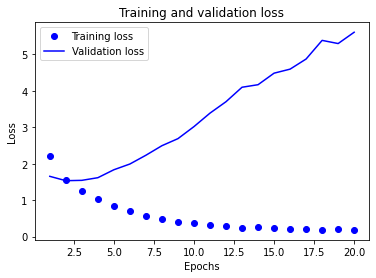

In [45]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [46]:
results = model.evaluate(X_test, y_test)

8585/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [36]:
### ===============================================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

embedding_dim = 256
batch_size = 256

model = Sequential()
model.add(Embedding(42925, 256))
model.add(Dropout(0.3))
model.add(Conv1D(256, 3, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

np_X_train = np.array(X_train)
np_y_train = np.array(y_train)

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(np_X_train, np_y_train, epochs = 20, callbacks=[es, mc])

Train on 34340 samples
Epoch 1/20
34340/34340 [==============================] - 196s 6ms/sample - loss: -1514002656.6754 - acc: 0.0076
Epoch 2/20
34340/34340 [==============================] - 195s 6ms/sample - loss: -39714926129.6792 - acc: 0.0076
Epoch 3/20
34340/34340 [==============================] - 192s 6ms/sample - loss: -211842112584.6402 - acc: 0.0076
Epoch 4/20
34340/34340 [==============================] - 195s 6ms/sample - loss: -623703719130.6362 - acc: 0.0076
Epoch 5/20
34340/34340 [==============================] - 198s 6ms/sample - loss: -1380917604291.4070 - acc: 0.0076
Epoch 6/20
34340/34340 [==============================] - 196s 6ms/sample - loss: -2583866267441.1724 - acc: 0.0076
Epoch 7/20
34340/34340 [==============================] - 195s 6ms/sample - loss: -4357193447473.8579 - acc: 0.0076
Epoch 8/20
34340/34340 [==============================] - 198s 6ms/sample - loss: -6808977984274.0410 - acc: 0.0076
Epoch 9/20
34340/34340 [==============================] 

34340/34340 [==============================] - 187s 5ms/sample - loss: -145218430248407.2812 - acc: 0.0076


In [ ]:

# 모델 생성
model = Sequential()

model.add(Embedding(30000,100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# 모델 설정
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 모델 학습
model.fit(X_train,
          y_train,
          epochs=100,
          batch_size=60,
          validation_split=0.2)

# 모델 평가
result = model.evaluate(X_test, y_test)
print('loss =', result[0])
print('accuracy=', result[1])